# Robust Featureとnon Robust Featureを持つデータセットの作成

## Robust Feature

## model load

In [117]:
import torch
from models.wideresnet import WideResNetProp

model = WideResNetProp(depth=34)
model.load_state_dict(torch.load('../../model-wideres-epoch99.pt'))

<All keys matched successfully>

## dataset loadする

In [118]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=False, transform=transform_train)
data_loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)

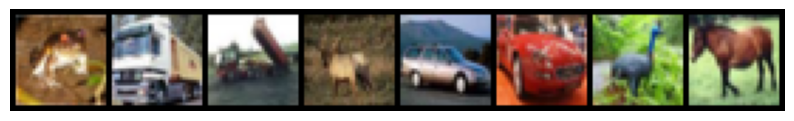

torch.Size([8, 3, 32, 32])

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# データローダーからバッチを取得
data_iter = iter(data_loader)
images, labels = data_iter.next()

# バッチから数枚の画像を表示する関数
def imshow(img):
    img = img
    npimg = img.numpy()
    np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 画像を表示
plt.figure(figsize=(10, 4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()
images[:8].shape


In [120]:
x_natural = images[:8].cuda()
type(x_natural)
x_random = images[-8:].cuda()
x_random.shape

torch.Size([8, 3, 32, 32])

## L2-PGD

In [121]:
model = model.cuda()
output = model(x_natural)
print('出力結果 :', output[0].shape)
print('中間特徴量 :', output[1].shape)

出力結果 : torch.Size([8, 10])
中間特徴量 : torch.Size([8, 640, 8, 8])


In [122]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn as nn

# epsilon = 8 / 255
epsilon = 0.1
perturb_steps = 1000
batch_size = len(x_natural)
# criterion_kl = torch.nn.KLDivLoss(size_average=False)
criterion_MSE = nn.MSELoss()
model = model.cuda()

# delta = 0.001 * torch.randn(x_natural.shape).cuda().detach()
# delta = Variable(delta.data, requires_grad=True)
x_adv = torch.randn(x_natural.shape).cuda().detach()
x_adv.requires_grad = True
# Setup optimizers
optimizer_delta = optim.SGD([x_adv], lr=0.1)

for _ in range(perturb_steps):
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        # loss = (-1) * criterion_kl(F.log_softmax(model(adv)[1], dim=1), F.softmax(model(x_natural)[1], dim=1))
        loss = criterion_MSE(model(x_adv)[1], model(x_natural)[1])
    if _ % 100 == 0:
        print('loss : ', loss)
    loss.backward()
    # renorming gradient
    # breakpoint()
    # print(x_adv.grad)
    grad_norms = x_adv.grad.view(batch_size, -1).norm(p=2, dim=1)
    x_adv.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        x_adv.grad[grad_norms == 0] = torch.randn_like(x_adv.grad[grad_norms == 0])
    optimizer_delta.step()
    # projection
    # x_adv.data.add_(x_natural)
    # x_adv = torch.clamp(x_adv.detach(), 0.0, 1.0).clone().requires_grad_(True) 
    # x_adv = torch.clamp(x_adv, 0.0, 1.0)
    # x_adv.requires_grad_()
    # x_adv.data.renorm_(p=2, dim=0, maxnorm=epsilon)
# x_adv = Variable(x_natural + delta, requires_grad=False)

loss :  tensor(0.0781, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward>)
loss :  tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


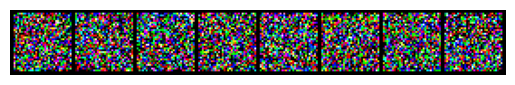

In [123]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))


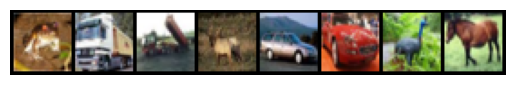

In [124]:
imshow(torchvision.utils.make_grid(x_natural.cpu().detach()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


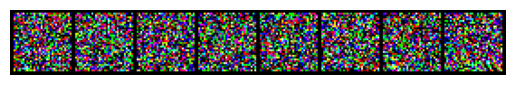

In [180]:
imshow(torchvision.utils.make_grid(torch.randn(x_natural.shape).cpu().detach()))

In [126]:
epsilon = 0.3
perturb_steps = 333
batch_size = len(x_natural)
# criterion_kl = torch.nn.KLDivLoss(size_average=False)
criterion_MSE = nn.MSELoss()
model = model.cuda()


# delta = torch.randn(x_natural.shape).cuda().detach()
delta = x_random.clone().detach().cuda()
delta = Variable(delta.data, requires_grad=True)
# Setup optimizers
optimizer_delta = optim.SGD([delta], lr=epsilon)
for i in range(perturb_steps):
    adv = delta
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        # loss = (-1) * criterion_kl(F.log_softmax(model(adv), dim=1),
                                #    F.softmax(model(x_natural), dim=1))
        loss = criterion_MSE(model(adv)[1], model(x_natural)[1])
    loss.backward()
    if i % 100 == 0:
        print(f'loss ({i}): {loss}')
    # renorming gradient
    grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
    delta.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
    optimizer_delta.step()
    # projection
    # delta.data.add_(x_random)
    # delta.data.clamp_(0, 1).sub_(x_random)
    # delta.data.renorm_(p=2, dim=0, maxnorm=epsilon)
    
    # これするとよくなる
    delta.data.clamp_(0, 1)
x_adv = Variable(adv, requires_grad=False)

loss (0): 0.10101979225873947
loss (100): 0.013051477260887623
loss (200): 0.009420327842235565
loss (300): 0.007450566627085209


In [127]:
nn.MSELoss()(model(x_adv)[1], model(x_natural)[1])

tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward>)

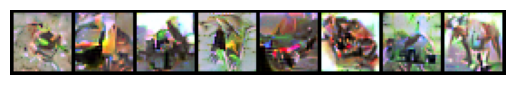

In [128]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))

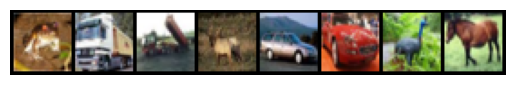

In [129]:
imshow(torchvision.utils.make_grid(x_natural.cpu().detach()))

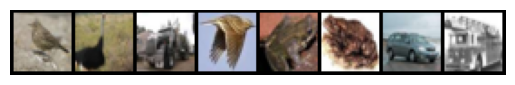

In [130]:
imshow(torchvision.utils.make_grid(x_random.cpu().detach()))

## non Robust Feature

In [132]:
# standard training model
from models.resnet import ResNet50

# model_s = WideResNetProp(depth=34)
model_s = ResNet50().cuda()
# model_s.load_state_dict(torch.load('../../wideres34-10.pt'))
model_s.load_state_dict(torch.load('../results/model-cifar-ResNet50/model-res-epoch100.pt'))


<All keys matched successfully>

In [155]:
x_natural = images[10:18].cuda()
y = labels[:8].cuda()
# t = labels[-18:-10].cuda()
t = (y + 1) % 10

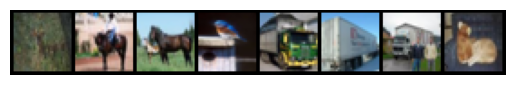

In [156]:
imshow(torchvision.utils.make_grid(x_natural.cpu().detach()))

In [175]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn as nn

# epsilon = 8 / 255
step_size = 0.1
epsilon = 1.0
perturb_steps = 100
batch_size = len(x_natural)

criterion_CE = nn.CrossEntropyLoss()
model_s = model_s.cuda()

delta = torch.randn(x_natural.shape).cuda().detach()
delta = Variable(delta.data, requires_grad=True)

# Setup optimizers
optimizer_delta = optim.SGD([delta], lr=step_size)

for _ in range(perturb_steps):
    adv = x_natural + delta
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        loss = criterion_CE(model_s(adv), t)
    loss.backward()
    # renorming gradient
    grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
    delta.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
    optimizer_delta.step()
    # projection
    delta.data.add_(x_natural)
    delta.data.clamp_(0, 1).sub_(x_natural)
    delta.data.renorm_(p=2, dim=0, maxnorm=epsilon)
x_adv = Variable(x_natural + delta, requires_grad=False)

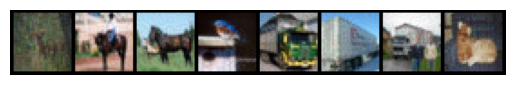

In [176]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))

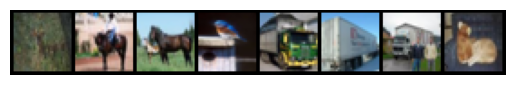

In [177]:
imshow(torchvision.utils.make_grid(x_natural.cpu().detach()))

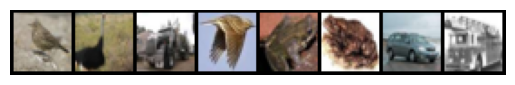

In [178]:
imshow(torchvision.utils.make_grid(x_random.cpu().detach()))

In [179]:
torch.norm(delta[0], p=2)


tensor(1.0000, device='cuda:0', grad_fn=<NormBackward1>)